In [1]:
import plotting

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-uofeb5vt because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import tensorflow as tf
tf.__version__

2026-02-10 13:37:36.007427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.11.1'

2.4000000000000004


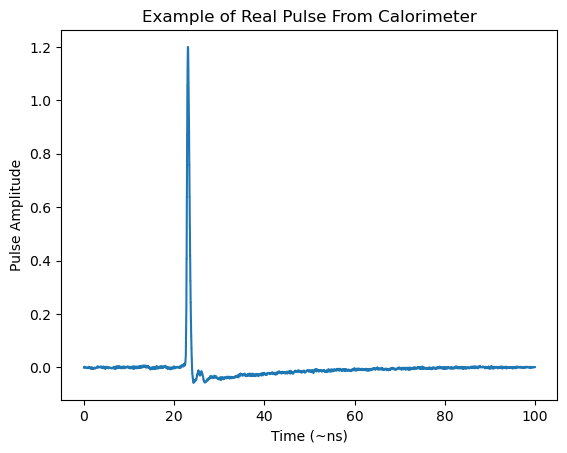

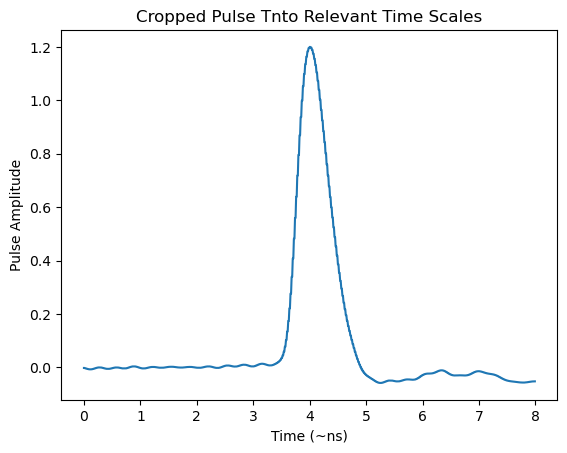

In [9]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import tensorflow.keras.models 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
fig, ax=plt.subplots()

# --- Constants ---
INPUT_FILE = 'hgdream/Sensl_FastOut_AveragePulse_1p8GHzBandwidth.feather'
SAVE_DIR = '1Conv_checkpoints_running'
LOG_FILE = '1Conv_3pulse_noise_tb23.csv'
SAVE_DIR2 = '1Conv_checkpoints_running2'
LOG_FILE2 = '1Conv_3pulse_noise_tb232.csv'
MODEL_NAME_TEMPLATE = '1Conv_2pulse_noise.loss_{val_loss:01.5f}.e{epoch:03d}_deconv.h5'
MODEL_NAME_TEMPLATE2 = '1Conv_2pulse_noise.loss_{val_loss:01.5f}.e{epoch:03d}_deconv2.h5'
NUM_EVENTS = 5000
TIME_STEPS = 80 # divides width_cutoff
width_cutoff = 800
SCALE_FACTOR = 12.0 / 10.0
VAL_SPLIT = 0.1
noise_factor = 0.2              #percent compared to the amplitude of a signal
num_pulses= 5
varPulses = True
amplVar = 1.414

center = 2306
weighted_amp = 1.2*width_cutoff/TIME_STEPS
noise = noise_factor*weighted_amp

print(noise)

# --- Load and Normalize Data ---
df = pd.read_feather(INPUT_FILE)

df['data_ch0'] = df['data_ch0'] / df['data_ch0'].max() * SCALE_FACTOR
df = pd.DataFrame(np.repeat(df.values, 2, axis=0), columns=df.columns)
x = np.arange(10000,dtype = float)/10000 * 100
# Crop data and reset index
plt.plot(x,df['data_ch0'].values)
plt.title("Example of Real Pulse From Calorimeter")
plt.xlabel("Time (~ns)")
plt.ylabel("Pulse Amplitude")
plt.show()

left = center - width_cutoff//2
right = center + width_cutoff//2
df = df[left:right].reset_index(drop=True)
x = x[left:right] - x[left]
plt.plot(x,df['data_ch0'].values)
plt.xlabel("Time (~ns)")
plt.ylabel("Pulse Amplitude")
plt.title("Cropped Pulse Tnto Relevant Time Scales")
plt.show()

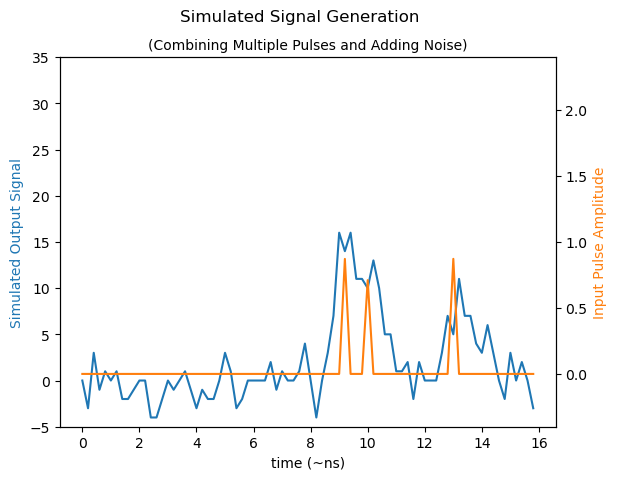

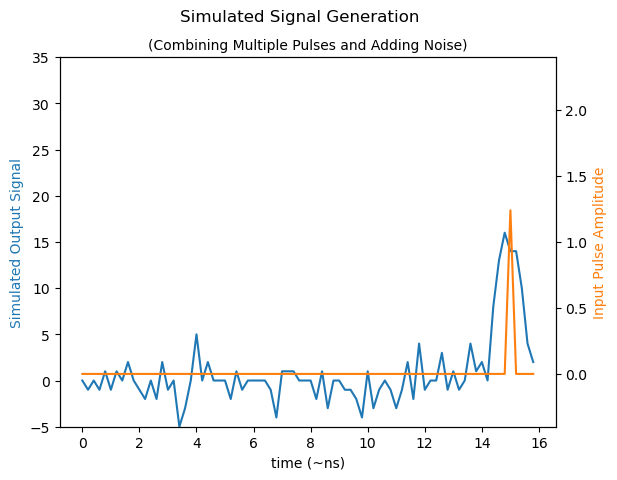

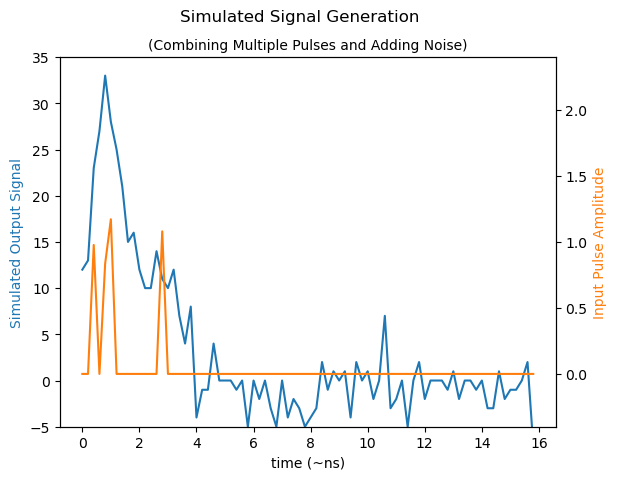

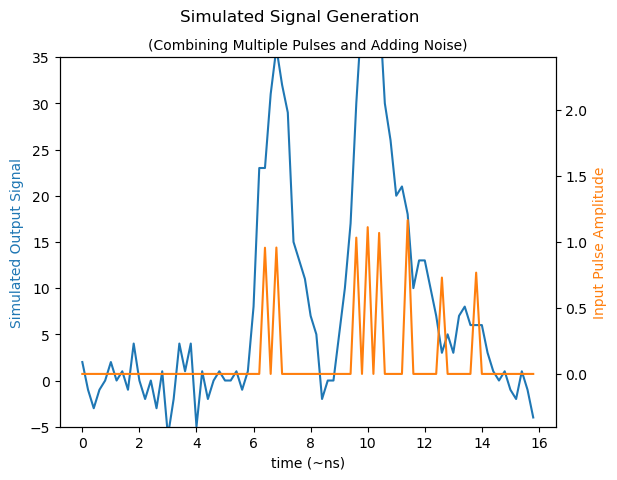

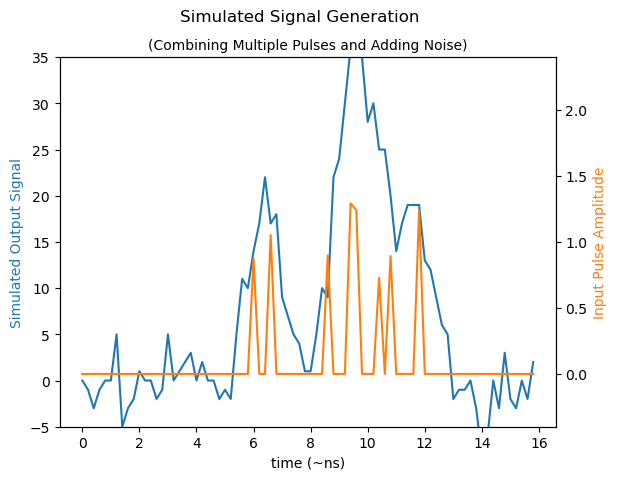

In [10]:
# --- Noise Function ---
def add_noise(data):
    """Add Gaussian noise to a Pandas Series."""
    noisy = data.copy()
    for i in range(len(noisy)):
        add = random.gauss(0.0,noise)
        noisy.iloc[i] += add
    return noisy

# --- Generate Synthetic Dataset ---

X_data = np.zeros((NUM_EVENTS, TIME_STEPS))
y_data = np.zeros((NUM_EVENTS, TIME_STEPS))
temp_df = df.copy()
'''
def make_data(NUM_EVENTS,TIME_STEPS,X_data,y_data,showcase = True):
    for event in range(NUM_EVENTS):
        shift = random.randint(1, 490)
        #print(shift)
        jitter = random.randint(-1100, 490)
        #print(jitter)
        ampl_r = random.uniform(1 / 1.414, 1.414)
        ampl_a = random.uniform(0.8, 1.6)
        
        temp_df = df.copy()
        temp_df['base'] = temp_df['data_ch0'].shift(jitter).fillna(0)
        temp_df['composite']=add_noise(temp_df['base']* ampl_a * ampl_r)
        y_data[event, int((306 + jitter) / (800/TIME_STEPS))] = ampl_a * ampl_r
        for i in range(num_pulses-1):

            shift = random.randint(-790-(306+jitter), 790-(306+jitter))

            ampl_r = random.uniform(1 / 1.414, 1.414)
            ampl_a = random.uniform(0.8, 1.6)
            temp_df['shift'] = temp_df['data_ch0'].shift(shift + jitter).fillna(0)
            temp_df['composite'] = temp_df['composite'] + temp_df['shift'] * ampl_a / ampl_r
            y_data[event, int((306 + shift + jitter) / 10)] = ampl_a / ampl_r



        # Downsample by grouping
        temp_df = temp_df.groupby(temp_df.index // (800/TIME_STEPS)).sum()
        temp_df['time'] = np.arange(0.0, TIME_STEPS * 0.2, 0.2)
        temp_df['composite'] = temp_df['composite'].astype(int)


        # Populate arrays
        print(event, temp_df['composite'])
        X_data[event, :] = temp_df['composite'].values

        #if event % 100 == 0 and showcase:
            #print(f"Generated {event} / {NUM_EVENTS} samples")
    return temp_df
'''
def make_data(NUM_EVENTS,TIME_STEPS,X_data,y_data,showcase = True):
    for event in range(NUM_EVENTS):
        if varPulses:
            num_pulses = round(random.uniform(1,10))
        middle = width_cutoff//2
        shift = random.randint(50,width_cutoff - 50) #So the pulse isnt at the very end
        ampl_r = random.uniform(1 / amplVar, amplVar)
        ampl_a = 1         #random.uniform(0.8, 1.6)
        
        temp_df = df.copy()
        temp_df['base'] = temp_df['data_ch0'].shift(shift-middle).fillna(0)
        temp_df['composite']=temp_df['base'] * ampl_a * ampl_r
        y_data[event, int(shift / (width_cutoff/TIME_STEPS))] = ampl_a * ampl_r
        for i in range(num_pulses-1):
            jitter = random.randint(max(shift-middle//2,0),min(shift+middle//2,width_cutoff-1))
            ampl_r = random.uniform(1 / amplVar, amplVar)
            ampl_a = 1 # random.uniform(0.8, 1.6)
            temp_df['shift'] = temp_df['data_ch0'].shift(jitter-middle).fillna(0)
            temp_df['composite'] = temp_df['composite'] + temp_df['shift'] * ampl_a / ampl_r
            y_data[event, int(jitter / (width_cutoff/TIME_STEPS))] = ampl_a / ampl_r



        # Downsample by grouping
        temp_df = temp_df.groupby(temp_df.index // (width_cutoff/TIME_STEPS)).sum()
        temp_df['composite'] = add_noise(temp_df['composite'])
        temp_df['time'] = np.arange(0.0, TIME_STEPS * 0.2, 0.2)
        temp_df['composite'] = temp_df['composite'].astype(int)

        # Populate arrays
        X_data[event, :] = temp_df['composite'].values

        #if event % 100 == 0 and showcase:
            #print(f"Generated {event} / {NUM_EVENTS} samples")
    return temp_df
temp_df = make_data(NUM_EVENTS,TIME_STEPS,X_data,y_data)
""""import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Gaussian function
def func(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

x = temp_df['time']
y = temp_df['composite']

initial_guess = [max(y), np.mean(x), np.std(x)]
popt, _ = curve_fit(func, x, y, p0=initial_guess)


ym = func(x, *popt)

plt.plot(x, y, label='Original')

plt.plot(x, ym, label='Fitted')
plt.legend()
plt.show()

print("Fitted parameters:", popt)"""

# --- Reshape Data for Model ---
def displayModel(index, X_data_ex, y_data_ex):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("time (~ns)")
    ax1.set_ylabel('Simulated Output Signal', color = 'tab:blue') 
    ax1.set_ylim(-5,35)
    ax1.plot(temp_df['time'],X_data_ex[index,:], "C0-")
    
    ax2 = ax1.twinx()
    ax2.set_ylabel("Input Pulse Amplitude", color = 'tab:orange')
    ax2.set_ylim(-0.4,2.4)
    plt.plot(temp_df['time'],y_data_ex[index,:], "C1-")
    plt.title("Generation of Simulated Signals")
    plt.suptitle("Simulated Signal Generation")
    plt.title("(Combining Multiple Pulses and Adding Noise)", fontsize = 10)
    plt.savefig('pulse.png')
    plt.show()
for i in range(5):
    displayModel(i, X_data, y_data)

"""fig, ax = plt.subplots()
im = ax.imshow(X_data, aspect='equal')
fig.set_size_inches(6, 6)
ax.set_title('X_data')
plt.colorbar(im)
plt.savefig('X.png')
fig, ax = plt.subplots()
im2 = ax.imshow(y_data, aspect ='equal')
fig.set_size_inches(6, 6)
ax.set_title('y_data')
plt.colorbar(im2)
plt.savefig('y.png')
for i in range(NUM_EVENTS):
    for j in range(TIME_STEPS):
        if y_data[i][j]!=0:
            y_data[i][j]=1"""
X_data = np.reshape(X_data, (NUM_EVENTS, TIME_STEPS,1))
y_data = np.reshape(y_data, (NUM_EVENTS, TIME_STEPS,1))

In [11]:
np.save("X_Data_Bank", X_data)
np.save("Y_Data_Bank", y_data)